In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import feniax.plotools.utils as putils
import feniax.preprocessor.solution as solution  

import feniax.preprocessor.configuration as configuration  
from feniax.preprocessor.inputs import Inputs
import feniax.feniax_main
import jax.numpy as jnp
import pathlib

import feniax.plotools.utils as putils
import feniax.preprocessor.solution as solution  

ImportError: cannot import name 'display' from 'IPython.core.display' (/home/rpalacio/anaconda3/envs/feniax/lib/python3.11/site-packages/IPython/core/display.py)

In [2]:

def plot_multiple_2d(
    x_list,
    y_list,
    labels=None,
    colors=None,
    line_styles=None,
    markers=None,
    title="2D Plot",
    x_label="t",
    y_label="Y-Axis",
    xlim=None,
    ylim=None,
    grid=True,
    figsize=(10, 6),
    legend=True,
    save_path=None,
    show=True
):
    """
    Plot multiple 2D datasets on the same plot with customization.

    Parameters:
        x_list (list of lists/arrays): List of x-data arrays.
        y_list (list of lists/arrays): List of y-data arrays.
        labels (list of str): Labels for each line (for legend).
        colors (list of str): Colors for each line.
        line_styles (list of str): Line styles for each line.
        markers (list of str): Marker styles for each line.
        title (str): Title of the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        grid (bool): Whether to show grid.
        figsize (tuple): Size of the figure.
        legend (bool): Whether to show legend.
        save_path (str): If specified, path to save the plot image.
        show (bool): Whether to display the plot.
    """

    plt.figure(figsize=figsize)

    num_lines = len(x_list)

    for i in range(num_lines):
        x = x_list[i] 
        y = y_list[i]
        label = labels[i] if labels and i < len(labels) else None
        color = colors[i] if colors and i < len(colors) else None
        linestyle = line_styles[i] if line_styles and i < len(line_styles) else '-'
        marker = markers[i] if markers and i < len(markers) else ''

        plt.plot(x, y, label=label, color=color, linestyle=linestyle, marker=marker)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if ylim is not None:
        plt.ylim(*ylim)   
    if grid:
        plt.grid(True)

    if legend and labels:
        plt.legend()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    if show:
        plt.show()

    plt.close()

def read_result_folders(base_path='.'):
    base = pathlib.Path(base_path)
    return [f.name for f in base.iterdir() if f.is_dir() and f.name.startswith('results_')]

def read_results():
    folders = read_result_folders()
    results = dict()
    for fi in folders:
        name = fi.split("results_")[1]
        print(f"Reading {name} ...")
        results[name] = solution.IntrinsicReader(fi)

    return results

In [43]:

v_x = 0.
v_y = 0.
v_z = 0.
omega_x = 0.
omega_y = 1.
omega_z = 0.
gravity_forces = False
gravity_label = "g" if gravity_forces else ""
label = 'm7'
num_modes = [8, 10]

inp = Inputs()
inp.log.level="error"
inp.engine = "intrinsicmodal"
inp.fem.connectivity = {'rbeam': None, 'lbeam': None}
inp.fem.Ka_name = f"./FEM/Ka_{label}.npy"
inp.fem.Ma_name = f"./FEM/Ma_{label}.npy"
inp.fem.eig_names = [f"./FEM/eigenvalsX_{label}.npy",
                     f"./FEM/eigenvecsX_{label}.npy"]
inp.fem.grid = f"./FEM/structuralGrid_{label}"
inp.fem.eig_type = "inputs"
inp.driver.typeof = "intrinsic"
inp.simulation.typeof = "single"
inp.system.name = "s1"
inp.system.solution = "dynamic"
inp.system.bc1 = 'free'
inp.system.xloads.gravity_forces = gravity_forces
inp.system.t1 = 10
inp.system.tn = 20000 * 20 + 1
inp.system.solver_library = "runge_kutta" #"diffrax" #
inp.system.solver_function = "ode"
inp.system.solver_settings = dict(solver_name="rk4")
inp.system.init_states = dict(q1=["nodal_prescribed",
                                  ([[v_x, v_y, v_z, omega_x, omega_y, omega_z],
                                    [v_x, v_y, v_z - omega_y * 1, omega_x, omega_y, omega_z],
                                    [v_x, v_y, v_z + omega_y * 1, omega_x, omega_y, omega_z]]
                                   ,)
                                  ]
                              )


for ni in num_modes:
    label_name = label + f"N{ni}" + gravity_label
    inp.fem.num_modes = ni  
    vz = [0., 0.2, 0.3, 0.4, 0.5, 0.6]
    for i, vzi in enumerate(vz):
        label_i = label_name + f"vz{i}"
        inp.driver.sol_path= pathlib.Path(
            f"./results_sym{label_i}")
        inp.system.init_states = dict(q1=["nodal_prescribed",
                                          ([[v_x, v_y, v_z, omega_x, omega_y, omega_z],
                                            [v_x, v_y, v_z - omega_y * 1 + vzi, omega_x, omega_y, omega_z],
                                            [v_x, v_y, v_z + omega_y * 1 + vzi, omega_x, omega_y, omega_z]]
                                           ,)
                                          ]
                                      )
        config =  configuration.Config(inp)
        sol = feniax.feniax_main.main(input_obj=config)
  
        inp.driver.sol_path= pathlib.Path(
            f"./results_antisym{label_i}")
        inp.system.init_states = dict(q1=["nodal_prescribed",
                                          ([[v_x, v_y, v_z, omega_x, omega_y, omega_z],
                                            [v_x, v_y, v_z - omega_y * 1 - vzi, omega_x, omega_y, omega_z],
                                            [v_x, v_y, v_z + omega_y * 1 + vzi, omega_x, omega_y, omega_z]]
                                           ,)
                                          ]
                                      )
        config =  configuration.Config(inp)
        sol = feniax.feniax_main.main(input_obj=config)          
# all solution data in the sol object (everything are tensors)
# for instance: sol.dynamicsystem_sys1.ra position of node [time_step, component, node_id]
# sol.dynamicsystem_s1.X1 for velocities and so on
# Multiple cases:1 ends here


____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________________END______________________
____________________FENIAX____________________
_____________

In [44]:
results = read_results()

Reading symm7N8vz ...
Reading antisymm7N10vz4 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading antisymm7N10vz3 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading antisymm7N8vz1 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading antisymm7N10vz2 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading antisymm7N10vz5 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading antisymm7N8vz0 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading symm7N10vz2 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading symm7N8vz0 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading symm7N10vz5 ...
***** Loading Couplings
***** Loading Modes
***** Loading DynamicSystem_s1
Reading symm7N10vz4 ...
***** Loading Couplings
***** Loading Mode

Note: 
- 8 modes simulation: 6RB modes +2 bending modes (symmetric and antysymmetric)
- 10 modes simulation: 6RB modes +2 bending modes + 2 roational modes in y (also symmetric and antysymmetric)

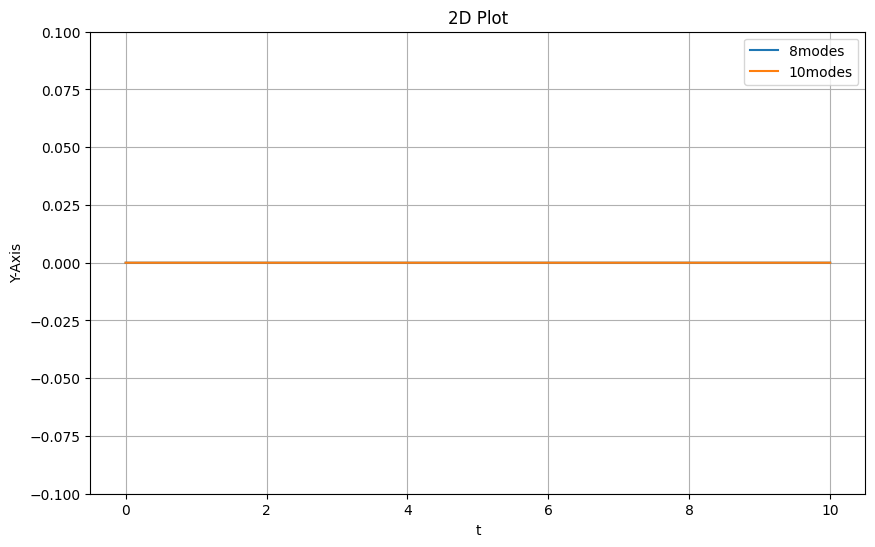

In [ ]:
# no velocity in z in node 0, good
x1, y1 = putils.pickIntrinsic2D(results["antisymm7N8vz2"].data.dynamicsystem_s1.t,
                              results["antisymm7N8vz2"].data.dynamicsystem_s1.X1,
                              fixaxis2=dict(node=0, dim=2)) 
x2, y2 = putils.pickIntrinsic2D(results["antisymm7N10vz2"].data.dynamicsystem_s1.t,
                                results["antisymm7N10vz2"].data.dynamicsystem_s1.X1,
                                fixaxis2=dict(node=0, dim=2)) 

fig = plot_multiple_2d([x1, x2], [y1, y2], labels=["8modes", "10modes"],ylim=[-0.1,0.1])

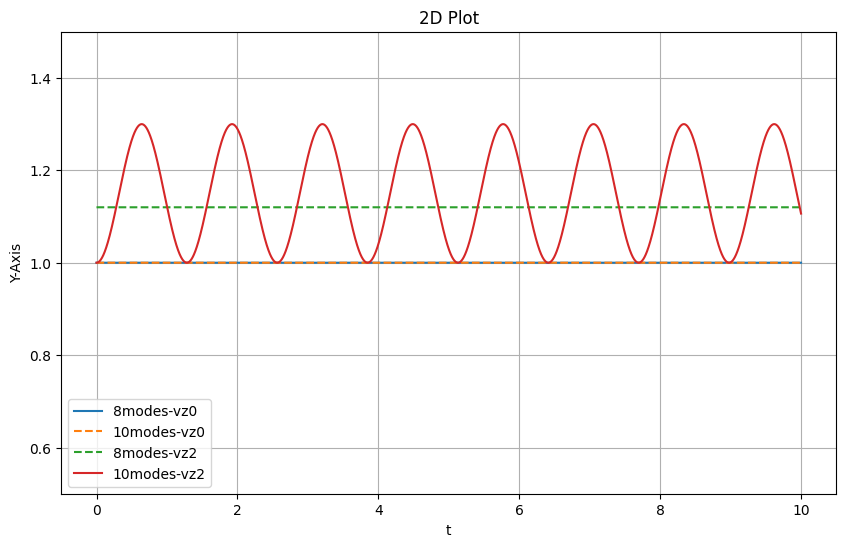

In [ ]:
# rotational velocity in node 0, 8 modes dont capture  antisymmetric oscillationa 
x1, y1 = putils.pickIntrinsic2D(results["antisymm7N8vz0"].data.dynamicsystem_s1.t,
                              results["antisymm7N8vz0"].data.dynamicsystem_s1.X1,
                              fixaxis2=dict(node=0, dim=4)) 
x2, y2 = putils.pickIntrinsic2D(results["antisymm7N10vz0"].data.dynamicsystem_s1.t,
                                results["antisymm7N10vz0"].data.dynamicsystem_s1.X1,
                                fixaxis2=dict(node=0, dim=4)) 
x3, y3 = putils.pickIntrinsic2D(results["antisymm7N8vz2"].data.dynamicsystem_s1.t,
                              results["antisymm7N8vz2"].data.dynamicsystem_s1.X1,
                              fixaxis2=dict(node=0, dim=4)) 
x4, y4 = putils.pickIntrinsic2D(results["antisymm7N10vz2"].data.dynamicsystem_s1.t,
                                results["antisymm7N10vz2"].data.dynamicsystem_s1.X1,
                                fixaxis2=dict(node=0, dim=4)) 

fig = plot_multiple_2d([x1,x2, x3,x4], [y1,y2,y3,y4], 
                       labels=["8modes-vz0", "10modes-vz0", "8modes-vz2", "10modes-vz2"],
                       ylim=[0.5,1.5],
                       line_styles=['-','--','--','-'])

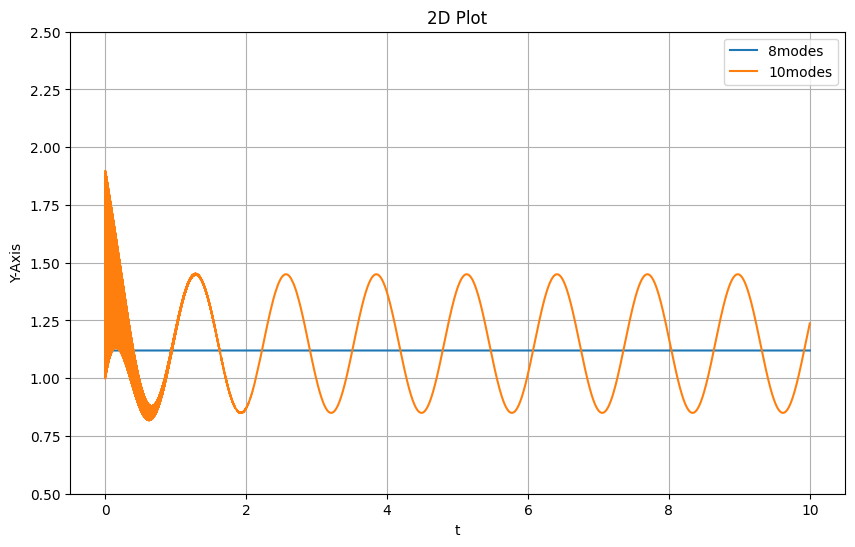

In [ ]:
# high-freq initial kick in rotational DoF OF tip nodes
x1, y1 = putils.pickIntrinsic2D(results["antisymm7N8vz2"].data.dynamicsystem_s1.t,
                              results["antisymm7N8vz2"].data.dynamicsystem_s1.X1,
                              fixaxis2=dict(node=1, dim=4)) 
x2, y2 = putils.pickIntrinsic2D(results["antisymm7N10vz2"].data.dynamicsystem_s1.t,
                                results["antisymm7N10vz2"].data.dynamicsystem_s1.X1,
                                fixaxis2=dict(node=1, dim=4)) 

fig = plot_multiple_2d([x1, x2], [y1, y2], labels=["8modes", "10modes"],ylim=[0.5,2.5])


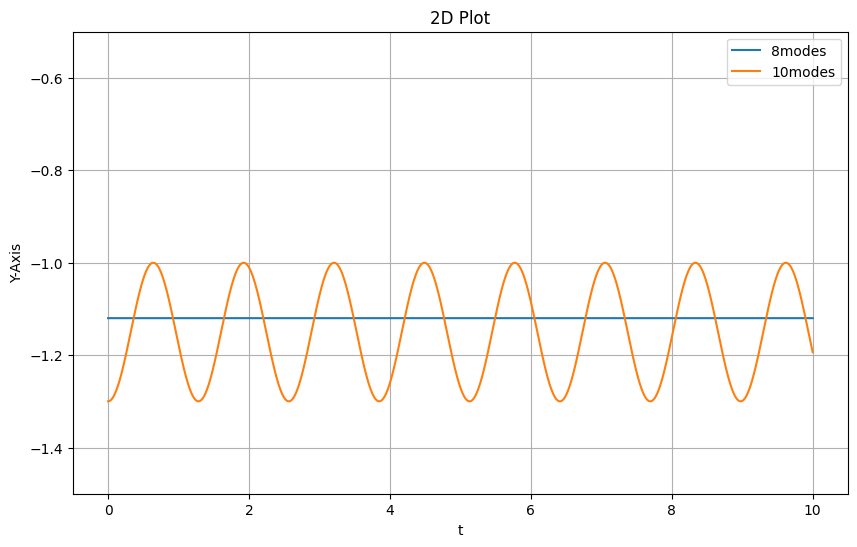

In [ ]:

# Initial velocity of tip node (-1 -0.3= -1.3 for vz2) not captured withou rotational DoF
x1, y1 = putils.pickIntrinsic2D(results["antisymm7N8vz2"].data.dynamicsystem_s1.t,
                              results["antisymm7N8vz2"].data.dynamicsystem_s1.X1,
                              fixaxis2=dict(node=1, dim=2)) 
x2, y2 = putils.pickIntrinsic2D(results["antisymm7N10vz2"].data.dynamicsystem_s1.t,
                                results["antisymm7N10vz2"].data.dynamicsystem_s1.X1,
                                fixaxis2=dict(node=1, dim=2)) 

fig = plot_multiple_2d([x1, x2], [y1, y2], labels=["8modes", "10modes"],ylim=[-1.5,-0.5])

